In [1]:
import os
import numpy as np
import imageio
import math as m
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import cv2
import glob
import scipy.io as sio
from natsort import natsorted
import pickle
# %matplotlib inline
%matplotlib notebook
from commons import skeleton_utils
from PIL import Image, ImageDraw
from io import BytesIO
import cv2
%matplotlib inline
from commons import vis_image as vis


commons/vis_image.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/data/vcl/sid/rahul/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/data/vcl/sid/rahul/local/lib/python2

In [2]:
def fig2data(fig):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()

    # Get the RGBA buffer from the figure
    w, h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = (w, h, 4)

    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll(buf, 3, axis=2)[:,:,:3]
    return buf

def show_images(images, step, path_to_save, cols = 1, titles = None):
  """Display a list of images in a single figure with matplotlib.
  
  Parameters
  ---------
  images: List of np.arrays compatible with plt.imshow.
  
  cols (Default = 1): Number of columns in figure (number of rows is 
                      set to np.ceil(n_images/float(cols))).
  
  titles: List of titles corresponding to each image. Must have
          the same length as titles.
  """
  assert((titles is None) or (len(images) == len(titles)))
  n_images = len(images)
  if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
  fig = plt.figure()
  for n, (image, title) in enumerate(zip(images, titles)):
      a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
      if image.ndim == 2:
          plt.gray()
      plt.imshow(image)
      a.set_title(title)
  fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
  fig_img = fig2data(fig)
  plt.savefig(path_to_save+"/results_"+str(step)+".jpg")
  # plt.show()
  plt.close(fig)
  return fig_img



limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]
# limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 0, 12, 13]

def get_figure():           
    fig = plt.figure(frameon=False, figsize=(8, 8))
    fig.clf()
    return fig


def fig2rgb_array(fig, expand=True):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    shape = (nrows, ncols, 3) if not expand else (1, nrows, ncols, 3)
    return np.fromstring(buf, dtype=np.uint8).reshape(shape)


def figure_to_summary(fig, iteration_no,  train_writer, vis_summary, vis_placeholder, mode=None):
    image = fig2rgb_array(fig)

    # print(" gg", vis_placeholder)

    # if mode=='test':
    #     test_writer.add_summary(vis_summary.eval(feed_dict={vis_placeholder: image}), global_step= iteration_no )
    # else:    
    train_writer.add_summary(vis_summary.eval(feed_dict={vis_placeholder: image}), global_step= iteration_no )
    plt.close(fig)

def draw_limbs_3d_plt(joints_3d, ax, limb_parents=limb_parents, z_flip = True):
    for i in range(joints_3d.shape[0]):
#         plt.text(i, (joints_3d[i, 0], joints_3d[i, 0]), str(i))
#         ax.text(joints_3d[i, 0], joints_3d[i, 1], joints_3d[i, 2], s=str(i))
        x_pair = [joints_3d[i, 0], joints_3d[limb_parents[i], 0]]
        y_pair = [joints_3d[i, 1], joints_3d[limb_parents[i], 1]]
        z_pair = [joints_3d[i, 2], joints_3d[limb_parents[i], 2]]
        ax.scatter(x_pair[0], y_pair[0], z_pair[0], c='black', s=80)
        ax.scatter(x_pair[1], y_pair[1], z_pair[1], c='black', s=80)
        ax.plot(x_pair, y_pair, z_pair, color=clrs[i]/255.0, linewidth=5, antialiased=True)
#         if z_flip:
#             ax.plot(z_pair, x_pair, y_pair, linewidth=3, antialiased=True)
#         else:
#             ax.plot(x_pair, y_pair,z_pair, linewidth=3, antialiased=True)
#         dist = np.sqrt(np.square(x_pair[0]-x_pair[1]) + np.square(y_pair[0]-y_pair[1]) + np.square(z_pair[0]-z_pair[1]))
#         print ("distance ", i, "<->", limb_parents[i], " = ", dist)
#     ax.view_init(50, 210)    

def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
    ax = fig.add_subplot(subplot, projection='3d')

    lim = np.max(np.abs(joints_3d))
#     print("lim", lim)
    ax.view_init(azim=az, elev=ele)
    
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    grid = False
    if grid == False:
        ax.axis('off')
        ax.grid(False)
    
    return ax

def get_skeleton_plot(joints_3d, ax, limb_parents=limb_parents, title="", z_flip=True):
#     fig = plt.figure(frameon=False, figsize=(7, 7))
    draw_limbs_3d_plt(joints_3d, ax, limb_parents, z_flip=False)
    plt.title(title)


def plot_skeleton(joints_3d, ax, limb_parents=limb_parents, title="", z_flip=True):
    get_skeleton_plot(joints_3d, ax, limb_parents, title, z_flip=z_flip)

In [3]:
limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]
# limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 0, 12, 13]

clrs = np.array([[175,25,240],                               #1
   [25,128,128],[75,180,80],[170,170,70],[60,128,210],     #5
   [200,130,0],[180,30,145],[255,128,50],[240,50,128],     #9
   [200,20,110],[0,0,255],[128,128,0], [0,128,255],        #13
   [0,255,0],[255,0,128],[128,255,0],[255,0,0]])           #17

def draw_limbs_3d_plt(joints_3d, ax, limb_parents=limb_parents, z_flip = True):
    #     depth = np.stack([joints_3d[:,2], np.arange(17)],1)
    list1 = joints_3d[:,2]
    list2 = np.arange(17)
    list1, list2 = zip(*sorted(zip(list1, list2)))
    
    print (list2)
    for i in list2[::-1]:
#     for i in range(joints_3d.shape[0]):

#         plt.text(i, (joints_3d[i, 0], joints_3d[i, 0]), str(i))
#         ax.text(joints_3d[i, 0], joints_3d[i, 1], joints_3d[i, 2], s=str(i))
        x_pair = [joints_3d[i, 0], joints_3d[limb_parents[i], 0]]
        y_pair = [joints_3d[i, 1], joints_3d[limb_parents[i], 1]]
        z_pair = [joints_3d[i, 2], joints_3d[limb_parents[i], 2]]
        ax.scatter(x_pair[0], y_pair[0], z_pair[0], c='black', s=80)
        ax.scatter(x_pair[1], y_pair[1], z_pair[1], c='black', s=80)
        ax.plot(x_pair, y_pair, z_pair, color=clrs[i]/255.0, linewidth=5, antialiased=True)
#         if z_flip:
#             ax.plot(z_pair, x_pair, y_pair, linewidth=3, antialiased=True)
#         else:
#             ax.plot(x_pair, y_pair,z_pair, linewidth=3, antialiased=True)
            
        dist = np.sqrt(np.square(x_pair[0]-x_pair[1]) + np.square(y_pair[0]-y_pair[1]) + np.square(z_pair[0]-z_pair[1]))
#         print ("distance ", i, "<->", limb_parents[i], " = ", dist)
    # ax.view_init(10, 210)   

def get_skeleton_plot(joints_3d, ax, limb_parents=limb_parents, title="", z_flip=True):
#     fig = plt.figure(frameon=False, figsize=(7, 7))
    draw_limbs_3d_plt(joints_3d, ax, limb_parents, z_flip=False)
    plt.title(title)


def plot_skeleton(joints_3d, ax, limb_parents=limb_parents, title="", z_flip=True):
    get_skeleton_plot(joints_3d, ax, limb_parents, title, z_flip=z_flip)

# def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
#     ax = fig.add_subplot(subplot, projection='3d')

#     lim = np.max(np.abs(joints_3d))
# #     print("lim", lim)
#     ax.view_init(azim=az, elev=ele)
    
#     ax.set_xlim(-lim, lim)
#     ax.set_ylim(-lim, lim)
#     ax.set_zlim(-lim, lim)
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z')
    
#     return ax

# def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
#     ax = fig.add_subplot(subplot, projection='3d')

#     lim_max = np.max(joints_3d)
#     lim_min = np.min(joints_3d)
# #     print("lim", lim)
#     ax.view_init(azim=az, elev=ele)
    
#     ax.set_xlim(lim_min, lim_max)
#     ax.set_ylim(lim_min, lim_max)
#     ax.set_zlim(lim_min, lim_max)
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     ax.set_zlabel('z')
    
#     return ax

def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
    ax = fig.add_subplot(subplot, projection='3d')

    lim_max_x = np.amax(joints_3d[:, 0])
    lim_min_x = np.amin(joints_3d[:, 0])
    lim_max_y = np.amax(joints_3d[:, 1])
    lim_min_y = np.amin(joints_3d[:, 1])
    lim_max_z = np.amax(joints_3d[:, 2])
    lim_min_z = np.amin(joints_3d[:, 2])
    print (lim_max_x, lim_min_x)
#     print("lim", lim)
    ax.view_init(azim=az, elev=ele)
    
    ax.set_xlim(lim_min_x-1.0, lim_max_x+1.0)
    ax.set_ylim(lim_min_y-1.0, lim_max_y+1.0)
    ax.set_zlim(lim_min_z-1.0, lim_max_z+1.0)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    grid = False
    if grid == False:
        ax.axis('off')
        ax.grid(False)
    
    return ax

def vis_3d(skeleton_3d):
    fig = plt.figure(frameon=False, figsize=(10, 10))
#     az = 90
    ax = get_ax(skeleton_3d, fig, az=90, ele=0, subplot='121')
    plot_skeleton(skeleton_3d, ax, z_flip=False)
    ax.set_title("pred_3d_front_view")

    ax = get_ax(skeleton_3d, fig, az=60, ele=10, subplot='122')
    plot_skeleton(skeleton_3d, ax, z_flip=False)
    ax.set_title("pred_3d_side_view")

    return fig

def skeleton_to_image(skltn):
    '''
    skltn: batch of 3d skeletons
    '''
    fig = vis_3d(skltn[0])
    fig.savefig("skeleton_3d.png", transparent=True)
#     plt.close(fig)
#     fig_img = cv2.imread("skeleton_3d.png")[:, :, ::-1]


def pose_rotate(points, theta, batch_size):
    theta = theta * np.pi / 180.0
    cos_vals = np.cos(theta)
    sin_vals = np.sin(theta)
    row_1 = np.concatenate([cos_vals, -sin_vals], axis=1)# 90 x 2
    row_2 = np.concatenate([sin_vals, cos_vals], axis=1)# 90 x 2
    row_12 = np.stack((row_1, row_2), axis=1)#90 x 2 x 2
    zero_size_row1x2 = np.zeros([batch_size, 1, 2])#90 x 1 x 2
    r1x2xZero = np.concatenate([row_12, zero_size_row1x2], axis=1)
    stacker = np.array([0.0, 0.0, 1.0])
    third_cols = np.reshape(np.tile(stacker, batch_size), [batch_size, 3])
    third_cols = np.expand_dims(third_cols, 2)
    rotation_matrix = np.concatenate([r1x2xZero, third_cols], axis=2)
    return np.matmul(points.reshape([points.shape[0], 17, 3]), rotation_matrix)


def rotate_y_axis(points,theta,batch_size):
    theta = theta * np.pi / 180
    cos_vals = np.cos(theta)#90 x 1
    sin_vals = np.sin(theta)
    zero_vals = np.zeros((batch_size,1))
    ones_vals = np.ones((batch_size,1))
    row_1 = np.concatenate([cos_vals, zero_vals],axis =1)#90 x2
    row_2 = np.concatenate([zero_vals ,ones_vals],axis=1)# 90 x 2
    row_12 = np.stack((row_1, row_2), axis=1)#90 x 2 x 2
    temp_3 = np.stack((-sin_vals,zero_vals),axis =2)#90 x 1 x 2
    temp_32 = np.concatenate([row_12,temp_3],axis = 1)#90 x 3 x 2
    third_cols = np.concatenate([sin_vals,zero_vals,cos_vals],axis=1)#90 x 3
    third_cols = np.expand_dims(third_cols, 2)
    rotation_matrix = np.concatenate([temp_32, third_cols], axis=2)
    return np.matmul(points.reshape([points.shape[0], 17, 3]), rotation_matrix)


def augment_pose_seq(pose_seq,z_limit=(0,360),y_limit=(-90,90)):
    pose_seq = np.expand_dims(pose_seq, axis=1)
    thetas = np.random.uniform(z_limit[0],z_limit[1], pose_seq.shape[0])
    thetas = np.stack([thetas]*pose_seq.shape[1], 1)
    k=[]
    for ct, xx in enumerate(thetas):
        k.append(pose_rotate(pose_seq[ct], np.expand_dims(thetas[ct], 1), pose_seq[ct].shape[0]))
    k = np.stack(k, 0)

    thetas = np.random.uniform(y_limit[0],y_limit[1], k.shape[0])
    thetas = np.stack([thetas]*k.shape[1], 1)
    p=[]
    for ct, xx in enumerate(thetas):
        p.append(rotate_y_axis(k[ct], np.expand_dims(thetas[ct], 1), k[ct].shape[0]))
    p = np.stack(p, 0)
    return k



limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 11, 0, 13, 14, 15]

def skeleton_image(joints_2d, img):
    img_copy = img.copy()
#     colors = [(0,0,255), (0,255,0), (255,0,0), (255,0,255), (0,255,255), (255,255,0), (127,127,0), (0,127,0), (100,0,100), 
#           (255,0,255), (0,255,0), (0,0,255), (255,255,0), (127,127,0), (100,0,100), (50, 255, 100), (50, 50, 0)]
    
    colors = [(0,0,255), (0,255,0), (255,0,0), (255,0,255), (0,255,255), (255,255,0), (127,127,0), (0,127,0), (100,0,100), 
          (255,0,255), (0,255,0), (0,0,255), (255,255,0), (127,127,0), (100,0,100), (175,100,195), (255,125,25)]
    joints_2d = joints_2d
    for i in range(joints_2d.shape[0]):
        #         ax.text(joints_2d[i, 0], -joints_2d[i, 1], str(i))
        x_pair = [joints_2d[i, 0], joints_2d[limb_parents[i], 0]]
        y_pair = [joints_2d[i, 1], joints_2d[limb_parents[i], 1]]
        img_copy = cv2.line(img_copy, (int(x_pair[0]),int(y_pair[0])), (int(x_pair[1]),int(y_pair[1])), colors[i],4)

    return img_copy[:,:,::-1]




def get_rotmat_camera(alpha, beta, gamma):

    one_zero_zero = np.array([1., 0., 0.])
    zero_one_zero = np.array([0., 1., 0.])
    zero_zero_one = np.array([0., 0., 1.])
    # print
    R_x = np.stack([one_zero_zero,
                       np.stack([0., np.cos(alpha), -np.sin(alpha)], 0),
                       np.stack([0., np.sin(alpha), np.cos(alpha)], 0)], 0)

    #     print "Rx", R_x
    R_y = np.stack([np.stack([np.cos(beta), 0., np.sin(beta)], 0),
                       zero_one_zero,
                       np.stack([-np.sin(beta), 0., np.cos(beta)], 0)], 0)

    #     print "Ry", R_y
    # try with R_z as identity
    R_z = np.stack([np.stack([np.cos(gamma), -np.sin(gamma), 0.], 0),
                       np.stack([np.sin(gamma), np.cos(gamma), 0.], 0),
                       zero_zero_one], 0)

    #     print "Rz", R_z
    R = np.matmul(R_x, np.matmul(R_y, R_z))

    return R

def get_rotmat_batch_camera(angles_batch, batch_size=1):
    rotmats = []
    print (angles_batch )
    for xx in range(batch_size):
        alpha = angles_batch[xx][0]
        beta = angles_batch[xx][1]
        gamma = angles_batch[xx][2]
        rotmat = get_rotmat_camera(alpha, beta, gamma)
        rotmats.append(rotmat)
    return np.stack(rotmats, 0)

def get_projected_points_ortho(P, R, T, f, c):
    
    # translate
    translated = np.transpose(P, (0,2,1)) - T.astype(np.float32)

    # rotate
    X = np.matmul(R, translated)
   
    # project
    XX = np.stack([X[:,0,:], X[:,2,:]], 1)

#     Proj = (f * XX) + c
#     print ("Proj ", Proj.shape)
#     Proj = np.transpose(Proj, (0,2,1))
#     print ("Proj ", Proj.shape)
    return np.transpose(XX, (0,2,1)), np.transpose(X, (0,2,1)), np.transpose(X, (0,2,1))[:,:,1:2]

def get_projected_points_pers(P, R, T, f, c):

    # translate
    translated = np.transpose(P, (0,2,1)) - T.astype(np.float32) # tf.transpose(c,perm=[0,2,1])

    # rotate
    X = np.matmul(R, translated)

    X[:,0, :] = X[:,0, :] / (1. - X[:,1, :]/10.)
    X[:,2, :] = X[:,2, :] / (1. - X[:,1, :]/10.)
    XX = np.stack([X[:,0, :], X[:,2, :]], 1)

#     Proj = (f * XX) + c
#     print ("Proj ", Proj.shape)
#     Proj = np.transpose(Proj, (0,2,1))
#     print ("Proj ", Proj.shape)
    return np.transpose(XX, (0,2,1)), np.transpose(X, (0,2,1)), np.transpose(X, (0,2,1))[:,:,1:2]

def get_2d_skeleton(skeleton_3d, cam_angles):

    alpha = np.reshape(cam_angles[:, 0], (-1, 1))
    beta = np.reshape(cam_angles[:, 1], (-1, 1))
    gamma = np.reshape(cam_angles[:, 2], (-1, 1))

    angles_batch = np.concatenate([alpha, beta, gamma], 1)

    R = get_rotmat_batch_camera(angles_batch, skeleton_3d.shape[0])
    T = np.reshape(np.array([0.0, 0.0, 0.0]), (3,1))
    c = np.reshape(np.array([10.0, 10.0]), (2,1))
    f = np.reshape(np.array([64.0, 64.0]), (2,1))

    projs_2d, rot_ske, depth = get_projected_points_ortho(skeleton_3d, R, T, f, c)    # output y,x i.e y values greatly varying and x values not so much

    return projs_2d, rot_ske, depth





### HUMAN 3.6

In [4]:
# HUMAN 3.6
data_path = '/data/vcl/anirudh_rule_based/codes_2020/vneck/split_all_data/corrected_human36_test_data_center_crops_17j_vneck.mat'
k =  sio.loadmat(data_path)

In [5]:
r = np.random.choice(np.arange(len(k['images_path'])))

In [6]:
images_path = k['images_path'][r]
poses_3d = k['poses_3d'][r]
poses_2d = k['poses_2d'][r]
poses_3d = np.expand_dims(poses_3d,axis = 0)
poses_3d = np.expand_dims(poses_3d,axis = 1)
poses_3d = np.squeeze(augment_pose_seq(poses_3d , z_limit=(15,15),y_limit=(0,0)))


(2.132622558988516, -3.2753432887762046)
(16, 12, 11, 15, 14, 10, 13, 4, 0, 9, 7, 3, 6, 2, 5, 1, 8)
(2.132622558988516, -3.2753432887762046)
(16, 12, 11, 15, 14, 10, 13, 4, 0, 9, 7, 3, 6, 2, 5, 1, 8)


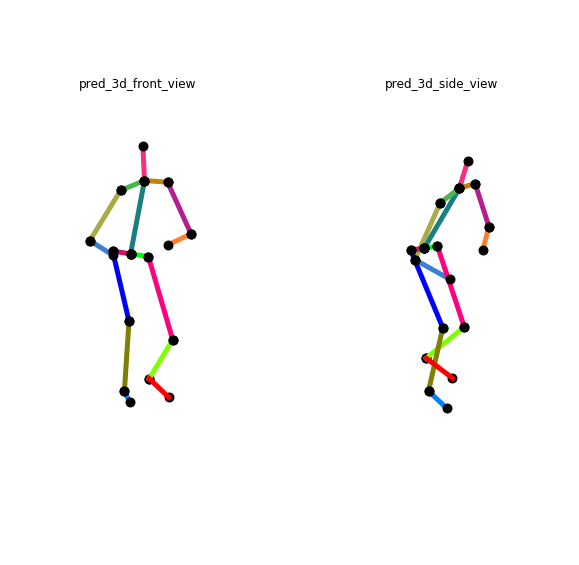

In [7]:
%matplotlib inline
skeleton_images = skeleton_to_image(np.stack([poses_3d, poses_3d], 0))

/data/vcl/sid/human36_parsed/parsed_data/center_crops/S11_Photo_54138969_video_855_945_19/crop_params_319_649_154_484_73.png          


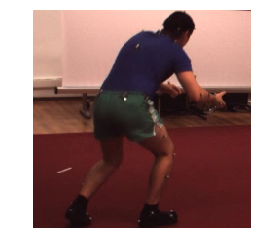

In [8]:
%matplotlib inline

# print (images_path)
# plt.figure(figsize=(20,10))

plt.imshow(mpimg.imread(images_path.strip()));
plt.axis('off');
image_name = '_'.join(images_path.split('/')[-2].split('_')[:2]).split(' ')[0]
print (images_path)
# plt.savefig('{}.png'.format(image_name),transparent=True)


In [9]:
start_id = int(images_path.split('/')[-2].split('_')[-3:][0])
idx = start_id + int(images_path.split('_')[-1].split('.')[0])
print (idx)

crop_params = images_path.split('/')[-1].split('_')[2:-1]


928


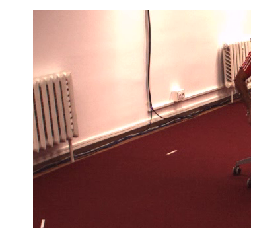

In [10]:
pose_image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/extracted_frames/S9_Sitting 1_55011271/{}.png'.format(idx))
pose_image = pose_image[int(crop_params[0]):int(crop_params[1]),int(crop_params[2]):int(crop_params[3])]
plt.axis('off');
plt.imshow(pose_image[:,:,::-1]);
# plt.savefig('{}.png'.format(image_name),transparent=True)


In [11]:
dataset = 'human'

In [12]:
os.system('mkdir ./final_results_2')
os.system('mkdir ./final_results_2/{}_{}/'.format(dataset,image_name))
os.system('mv {}.png ./final_results_2/{}_{}/'.format(image_name,dataset,image_name))
os.system('mv skeleton_3d.png ./final_results_2/{}_{}/'.format(dataset,image_name))


my_dict = {'image_name' :images_path , 'image_cropped_orig':pose_image , 'poses_3d' :poses_3d , 'poses_2d' : poses_2d}
sio.savemat('./final_results_2/{}_{}/{}_{}.mat'.format(dataset,image_name,dataset,image_name),my_dict)

In [13]:
os.listdir('./final_results_2/')

['S8_Directions_55011271_581.png',
 'S7_Smoking_60457274_2631.png',
 'S6_Walking_58860488_171.png',
 'human_S11_Photo',
 'S5_Photo_60457274_1184.png',
 'S6_Photo_60457274_606.png']

In [5]:
human_data = glob.glob('/data/vcl/sid/human36_parsed/parsed_data/extracted_frames/*/*.png')


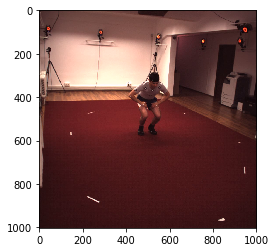

In [23]:
ran = np.random.choice(human_data)
plt.imshow(plt.imread(ran))

In [24]:
save_name = '_'.join(ran.split('/')[-2:])
print (save_name)
print ('cp -r {} ./final_results_2/{}'.format(ran,save_name))
os.system('cp -r {} /data/vcl/anirudh_rule_based/ground_truth_plot/get_all_plots/final_results_2/{}'.format(ran,save_name))

S8_SittingDown_60457274_88.png
cp -r /data/vcl/sid/human36_parsed/parsed_data/extracted_frames/S8_SittingDown_60457274/88.png ./final_results_2/S8_SittingDown_60457274_88.png


0

In [26]:
!ls final_results_2/

### YOUTUBE

In [18]:
youtube_gt_pose = sio.loadmat('/data/vcl/sid/in_the_w_parsed/poses_3d/dance_104.mat')['pose_3d']
youtube_gt_images = glob.glob('/data/vcl/sid/in_the_w_parsed/center_crops_full/dance_104/*.jpg')


In [36]:
youtube_gt_images = glob.glob('/data/vcl/sid/in_the_w_parsed/frames/*/*.png')


111659


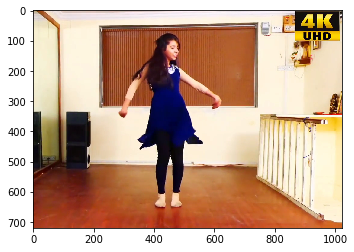

In [146]:
ran = np.random.choice(youtube_gt_images)
print (r)
plt.imshow(plt.imread(ran))

In [141]:
save_name = '_'.join(ran.split('/')[-2:])
print (save_name)
print ('cp -r {} ./final_results_2/{}'.format(ran,save_name))
os.system('cp -r {} /data/vcl/anirudh_rule_based/ground_truth_plot/get_all_plots/final_results_2/{}'.format(ran,save_name))

dance_9_frame0533.png
cp -r /data/vcl/sid/in_the_w_parsed/frames/dance_9/frame0533.png ./final_results_2/dance_9_frame0533.png


0

In [147]:
!ls final_results_2/

1_trimmed_frame1114.png  dance_39_frame1386.png
dance_104_frame1321.png  dance_4_frame1278.png
dance_104_frame3350.png  dance_6_frame0199.png
dance_105_frame0135.png  dance_7_frame0650.png
dance_106_frame1308.png  dance_7_frame1114.png
dance_10_frame0774.png	 dance_9_frame0533.png
dance_119_frame0121.png  S1_TakingPhoto_55011271_350.png
dance_122_frame1650.png  S5_Photo_60457274_1184.png
dance_125_frame2204.png  S6_Photo_60457274_606.png
dance_126_frame0845.png  S6_Walking_58860488_171.png
dance_16_frame1116.png	 S7_Smoking_60457274_2631.png
dance_17_frame0289.png	 S8_Directions_55011271_581.png
dance_17_frame0386.png	 S8_SittingDown_60457274_88.png
dance_20_frame1503.png


In [20]:

def getint(name):
    basename = name.split('_')[-1]
    num = basename.split('.')[0]
    return int(num)

youtube_gt_images.sort(key=getint)
youtube_gt_images = list(np.array(youtube_gt_images).copy())
# print(youtube_gt_images)


images_path = youtube_gt_images[r]

poses_3d = youtube_gt_pose[r]
poses_3d = np.expand_dims(poses_3d,axis = 0)
poses_3d = np.expand_dims(poses_3d,axis = 1)
poses_3d = np.squeeze(augment_pose_seq(poses_3d , z_limit=(-90,-90),y_limit=(0,0)))



(3.2047854401596645, -1.388088449549712)
(16, 12, 15, 11, 14, 10, 13, 0, 9, 7, 6, 3, 5, 2, 1, 4, 8)
(3.2047854401596645, -1.388088449549712)
(16, 12, 15, 11, 14, 10, 13, 0, 9, 7, 6, 3, 5, 2, 1, 4, 8)


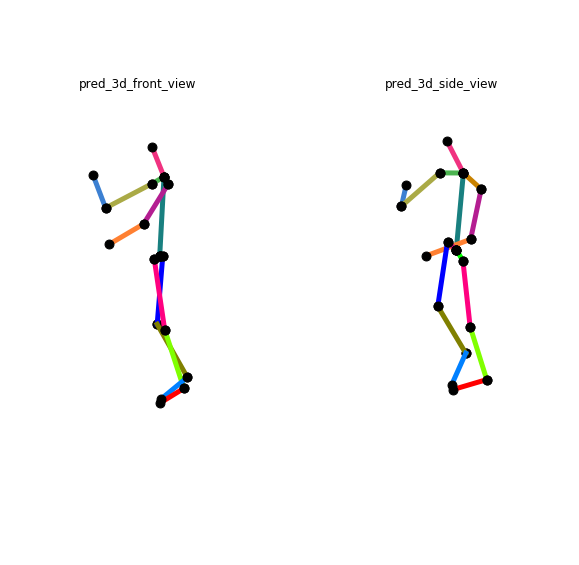

In [21]:
%matplotlib inline
skeleton_images = skeleton_to_image(np.stack([poses_3d, poses_3d], 0))

/data/vcl/sid/in_the_w_parsed/center_crops_full/dance_104/crop_params_106_427_222_543_629.jpg
dance_104


True

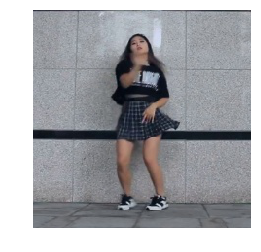

In [22]:
%matplotlib inline

# print (images_path)
# plt.figure(figsize=(20,10))

plt.imshow(mpimg.imread(images_path.strip()));
plt.axis('off');
image_name = '_'.join(images_path.split('/')[-2].split('_')[:2]).split(' ')[0]
print (images_path)
# plt.savefig('{}.png'.format(image_name),transparent=True)
print (image_name)
pose_image = cv2.imread(images_path.strip())
cv2.imwrite('{}.png'.format(image_name),pose_image)

In [23]:
idx = r 
print (idx)

crop_params = images_path.split('/')[-1].split('_')[2:-1]
crop_params

629


['106', '427', '222', '543']

In [24]:
# pose_image = cv2.imread('/data/vcl/sid/in_the_w_parsed/frames/dance_10/frame0122.png')
# pose_image = pose_image[int(crop_params[0]):int(crop_params[1]),int(crop_params[2]):int(crop_params[3])]
# plt.axis('off');
# plt.imshow(pose_image[:,:,::-1]);
# plt.savefig('{}.png'.format(image_name),transparent=True)


In [25]:
dataset = 'youtube'

In [26]:

os.system('mkdir ./other_sid_plots/{}_{}/'.format(dataset,image_name))
os.system('mv {}.png ./other_sid_plots/{}_{}/'.format(image_name,dataset,image_name))
os.system('mv skeleton_3d.png ./other_sid_plots/{}_{}/'.format(dataset,image_name))


my_dict = {'image_name' :images_path , 'image_cropped_orig':pose_image , 'poses_3d' :poses_3d , 'poses_2d' : poses_2d}
sio.savemat('./other_sid_plots/{}_{}/{}_{}.mat'.format(dataset,image_name,dataset,image_name),my_dict)

IOError: [Errno 2] No such file or directory: './other_sid_plots/youtube_dance_104/youtube_dance_104.mat'

In [ ]:
os.listdir('./other_sid_plots/')

### MPI

In [172]:
l = natsorted(glob.glob('/data/vcl/sid/mpi_parsed/parsed_data/test_data/extracted_frames/*/*.jpg'))


111659


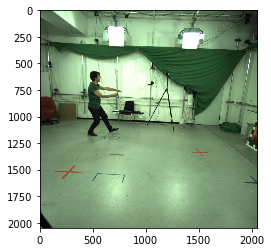

In [325]:
ran = np.random.choice(l)
print (r)

plt.imshow(plt.imread(ran))


In [ ]:
ran = np.random.choice(l)
print (r)

plt.imshow(plt.imread(ran))

In [323]:
save_name = '_'.join(ran.split('/')[-2:])
print (save_name)
print ('cp -r {} ./final_results_2/{}'.format(ran,save_name))
os.system('cp -r {} /data/vcl/anirudh_rule_based/ground_truth_plot/get_all_plots/final_results_2/{}'.format(ran,save_name))

TS4_img_005965.jpg
cp -r /data/vcl/sid/mpi_parsed/parsed_data/test_data/extracted_frames/TS4/img_005965.jpg ./final_results_2/TS4_img_005965.jpg


0

In [326]:
!ls final_results_2/
# !rm -rf final_results_2/TS2_img_001823.jpg

1_trimmed_frame1114.png  dance_39_frame1386.png		  TS1_img_004706.jpg
dance_104_frame1321.png  dance_4_frame1278.png		  TS2_img_000094.jpg
dance_104_frame3350.png  dance_6_frame0199.png		  TS2_img_004352.jpg
dance_105_frame0135.png  dance_7_frame0650.png		  TS2_img_004381.jpg
dance_106_frame1308.png  dance_7_frame1114.png		  TS2_img_004470.jpg
dance_10_frame0774.png	 dance_9_frame0533.png		  TS2_img_005818.jpg
dance_119_frame0121.png  S1_TakingPhoto_55011271_350.png  TS3_img_004554.jpg
dance_122_frame1650.png  S5_Photo_60457274_1184.png	  TS4_img_002949.jpg
dance_125_frame2204.png  S6_Photo_60457274_606.png	  TS4_img_005965.jpg
dance_126_frame0845.png  S6_Walking_58860488_171.png	  TS5_img_000101.jpg
dance_16_frame1116.png	 S7_Smoking_60457274_2631.png	  TS6_img_000267.jpg
dance_17_frame0289.png	 S8_Directions_55011271_581.png   TS6_img_000424.jpg
dance_17_frame0386.png	 S8_SittingDown_60457274_88.png
dance_20_frame1503.png	 TS1_img_001842.jpg


In [ ]:
images_path = l[r]
poses_3d = sio.loadmat('/data/vcl/sid/mpi_parsed/parsed_data/test_data/pose_3d/TS6.mat')['pose_3d']
# poses_3d = sio.loadmat('./LCRNet_v2.0/sid_plots.mat')['pose_3d']
poses_3d = poses_3d.reshape((-1,15,3))[r]
poses_2d = sio.loadmat('/data/vcl/sid/mpi_parsed/parsed_data/test_data/pose_2d/TS6.mat')['pose_2d']
poses_2d = poses_2d.reshape((-1,15,2))[r]
# poses_3d = skeleton_utils.fit_skeleton_frame(poses_3d)



left_foot = poses_3d[11]
right_foot = poses_3d[14]
poses_3d = poses_3d.tolist()
poses_3d.insert(12,left_foot)
poses_3d.append(right_foot)
poses_3d = np.array(poses_3d)


poses_3d = np.expand_dims(poses_3d,axis = 0)
poses_3d = np.expand_dims(poses_3d,axis = 1)
poses_3d = np.squeeze(augment_pose_seq(poses_3d , z_limit=(0,0),y_limit=(0,0)))

print (r)

In [ ]:
%matplotlib inline
skeleton_images = skeleton_to_image(np.stack([poses_3d, poses_3d], 0))

In [ ]:
%matplotlib inline

# print (images_path)
# plt.figure(figsize=(20,10))

pose_image = mpimg.imread(images_path.strip())

plt.imshow(pose_image);
plt.axis('off');
image_name = '_'.join(images_path.split('/')[-2].split('_')[:2]).split(' ')[0]
print (images_path)
# plt.savefig('{}.png'.format(image_name),transparent=True)
print (image_name)
pose_image = cv2.imread(images_path.strip())
cv2.imwrite('{}.png'.format(image_name),pose_image)

In [ ]:
dataset = 'mpi'

In [ ]:

os.system('mkdir ./new_sid_plots/{}_{}/'.format(dataset,image_name))
os.system('mv {}.png ./new_sid_plots/{}_{}/'.format(image_name,dataset,image_name))
os.system('mv skeleton_3d.png ./new_sid_plots/{}_{}/'.format(dataset,image_name))


my_dict = {'image_name' :images_path , 'image_cropped_orig':pose_image , 'poses_3d' :poses_3d , 'poses_2d' : poses_2d}
sio.savemat('./new_sid_plots/{}_{}/{}_{}.mat'.format(dataset,image_name,dataset,image_name),my_dict)

In [ ]:
ls

In [ ]:
os.listdir('./new_sid_plots/')

In [ ]:
rm -rf *.png

### 3DPW

In [8]:
l = natsorted(glob.glob('/data/vcl/sid/3dpw_latest/imageFiles/*/*.jpg'))




/data/vcl/sid/3dpw_latest/imageFiles/courtyard_shakeHands_00_0/image_00293.jpg


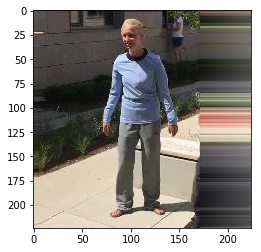

In [91]:
ran = np.random.choice(l)
print (ran)


plt.imshow(plt.imread(ran))

In [85]:
save_name = '_'.join(ran.split('/')[-2:])
print (save_name)
print ('cp -r {} ./final_results_2/{}'.format(ran,save_name))
os.system('cp -r {} /data/vcl/anirudh_rule_based/ground_truth_plot/get_all_plots/final_results_2/{}'.format(ran,save_name))

courtyard_jacket_00_0_image_00312.jpg
cp -r /data/vcl/sid/3dpw_latest/imageFiles/courtyard_jacket_00_0/image_00312.jpg ./final_results_2/courtyard_jacket_00_0_image_00312.jpg


0

In [86]:
!ls final_results_2/

1_trimmed_frame1114.png
courtyard_box_00_0_image_00631.jpg
courtyard_golf_00_0_image_00437.jpg
courtyard_jacket_00_0_image_00312.jpg
courtyard_jacket_00_0_image_00572.jpg
courtyard_laceShoe_00_0_image_00505.jpg
courtyard_relaxOnBench_01_0_image_00145.jpg
courtyard_relaxOnBench_01_0_image_00745.jpg
dance_104_frame1321.png
dance_104_frame3350.png
dance_105_frame0135.png
dance_106_frame1308.png
dance_10_frame0774.png
dance_119_frame0121.png
dance_122_frame1650.png
dance_125_frame2204.png
dance_126_frame0845.png
dance_16_frame1116.png
dance_17_frame0289.png
dance_17_frame0386.png
dance_20_frame1503.png
dance_39_frame1386.png
dance_4_frame1278.png
dance_6_frame0199.png
dance_7_frame0650.png
dance_7_frame1114.png
dance_9_frame0533.png
outdoors_climbing_02_0_image_00171.jpg
outdoors_freestyle_00_0_image_00036.jpg
outdoors_freestyle_00_0_image_00188.jpg
outdoors_slalom_00_0_image_00055.jpg
S1_TakingPhoto_55011271_350.png
S5_Photo_60457274_1184.png
S6_Photo_60457274_606.png
S6_Walking_58860488_

In [ ]:
import sys
import os.path as osp
import os
import cv2
import numpy as np
import random
import copy
import scipy.io as sio
import tensorflow as tf
import glob as glob
import json
from natsort import natsorted
import math
import imutils
import pickle
from skimage.color import rgb2hsv, hsv2rgb

datapath_3dpw = '/data/vcl/sid/3dpw_latest/imageFiles/'
datapath_3dpw_poses = '/data/vcl/sid/3dpw_latest/sequenceFiles/'
datapath_3dpw_masks = '/data/vcl/sid/3dpw_latest/masks/'

folders_3dpw = os.listdir(datapath_3dpw)




def do_aug(rgb_img):

    b_delta_val = np.random.random() / 8.0        # between (0. to 30.) of 255.
    c_delta_val = np.random.random() / 5.0 + 0.6         # between (0.6 to 0.8)
    h_delta_val = np.random.random() * 0.2 + 0.3   # between (0.3 to 0.5)

    hsv_img = rgb2hsv(rgb_img)
    hue_img = hsv_img[:, :, 0] + (h_delta_val if np.random.randint(2) > 0 else 0.)
    sat_img = hsv_img[:, :, 1] + (c_delta_val if np.random.randint(2) > 0 else 0.)
    value_img = hsv_img[:, :, 2] + (b_delta_val if np.random.randint(2) > 0 else 0.)
    aug_image = hsv2rgb(np.stack([hue_img, sat_img, value_img], 2))

    return aug_image

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def tilt_3d(pose_3d, angle):
    rotmat = np.asarray([[np.cos(angle), 0 , -np.sin(angle)],[0,1,0],[np.sin(angle), 0, np.cos(angle)]], dtype = np.float32)
    return np.dot(pose_3d, rotmat)

def perform_flip(points):
    points = np.stack([points[:,0] + 2*(112 - points[:,0]), points[:,1]], axis=1)
    points_flipped = np.stack([points[0], points[1], points[5], points[6], points[7], \
                                     points[2], points[3], points[4], points[8], points[13], \
                                     points[14], points[15], points[16], points[9], points[10], points[11], points[12]], axis=0)
    return points_flipped


def perform_tilt(points, tilt_angle):
    gauss_mu_x_tilt = ( (points[:,1] - 112.0) * np.cos(tilt_angle) - (points[:,0] - 112.0) * np.sin(tilt_angle) ) + 112.0
    gauss_mu_y_tilt = ( (points[:,1] - 112.0) * np.sin(tilt_angle) + (points[:,0] - 112.0) * np.cos(tilt_angle) ) + 112.0
    return np.stack([gauss_mu_y_tilt, gauss_mu_x_tilt], axis=1)

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def flip_image(image):
    return np.fliplr(image)

def flip_3d(pose_3d):
    #pose_3d_flip = np.dot(pose_3d , np.asarray([[-1,0,0],[0,-1,0],[0,0,1]], dtype = np.float32))
    skeleton_flipped_1  = pose_3d * np.asarray([-1, 1, 1], dtype = np.float32)
    skeleton_flipped = np.stack([skeleton_flipped_1[0,:], skeleton_flipped_1[1,:],
                                    skeleton_flipped_1[5,:], skeleton_flipped_1[6,:], skeleton_flipped_1[7,:],
                                    skeleton_flipped_1[2,:], skeleton_flipped_1[3,:], skeleton_flipped_1[4,:],
                                    skeleton_flipped_1[8,:], skeleton_flipped_1[13,:],skeleton_flipped_1[14,:],
                                    skeleton_flipped_1[15,:],skeleton_flipped_1[16,:],skeleton_flipped_1[9,:],
                                    skeleton_flipped_1[10,:],skeleton_flipped_1[11,:],skeleton_flipped_1[12,:]], axis=0)
    
    return skeleton_flipped

def unit_norm(mat, dim=1):
    norm = (np.sqrt(np.sum(mat ** 2, dim)) + 1e-9)
    norm = np.expand_dims(norm, dim)
    mat = mat / norm
    return mat

def normalize_3d_pose(pred_3d):
    pelvis = pred_3d[0,:]
    rhip = unit_norm(pred_3d[9,:], dim=0) * 1.05 + pelvis
    lhip = unit_norm(pred_3d[13,:], dim=0) * 1.05 + pelvis
    neck = unit_norm(pred_3d[1,:], dim=0) * 4.75 + pelvis
    rs = unit_norm(pred_3d[2,:]-pred_3d[1,:], dim=0) * 1.37 + neck
    re = unit_norm(pred_3d[3,:]-pred_3d[2,:], dim=0) * 2.8 + rs
    rh = unit_norm(pred_3d[4,:]-pred_3d[3,:], dim=0) * 2.4 + re
    ls = unit_norm(pred_3d[5,:]-pred_3d[1,:], dim=0) * 1.37 + neck
    le = unit_norm(pred_3d[6,:]-pred_3d[5,:], dim=0) * 2.8 + ls
    lh = unit_norm(pred_3d[7,:]-pred_3d[6,:], dim=0) * 2.4 + le
    head = unit_norm(pred_3d[8,:]-pred_3d[1,:], dim=0) * 2.0 + neck
    rk = unit_norm(pred_3d[10,:]-pred_3d[9,:], dim=0) * 4.2 + rhip
    ra = unit_norm(pred_3d[11,:]-pred_3d[10,:], dim=0) * 3.6 + rk
    rf = unit_norm(pred_3d[12,:]-pred_3d[11,:], dim=0) *2.0 + ra
    lk = unit_norm(pred_3d[14,:]-pred_3d[13,:], dim=0) * 4.2 + lhip
    la = unit_norm(pred_3d[15,:]-pred_3d[14,:], dim=0) * 3.6 + lk
    lf = unit_norm(pred_3d[16,:]-pred_3d[15,:], dim=0) *2.0 + la

    skeleton = np.concatenate([np.expand_dims(pelvis, axis=0), np.expand_dims(neck, axis=0), 
                           np.expand_dims(rs, axis=0), np.expand_dims(re, axis=0),
                           np.expand_dims(rh, axis=0), np.expand_dims(ls, axis=0),
                           np.expand_dims(le, axis=0), np.expand_dims(lh, axis=0),
                           np.expand_dims(head, axis=0), np.expand_dims(rhip, axis=0),
                           np.expand_dims(rk, axis=0), np.expand_dims(ra, axis=0),
                           np.expand_dims(rf, axis=0), np.expand_dims(lhip, axis=0), 
                           np.expand_dims(lk, axis=0), np.expand_dims(la, axis=0), 
                           np.expand_dims(lf, axis=0)], axis=0)
    return skeleton

def process_mask(mask_im):

    mask_bin = (mask_im[:,:] != 0)
    return mask_bin

def crop_and_resize(im_full, mask_full, pose_2d):

    #print ("Going inside")

    sh0 = im_full.shape[0]
    sh1 = im_full.shape[1]

    y_min = max(int(np.min(pose_2d[:,0]))-30,0)
    y_max = min(int(np.max(pose_2d[:,0]))+30,sh0)
    x_min = max(int(np.min(pose_2d[:,1]))-30,0)
    x_max = min(int(np.max(pose_2d[:,1]))+30,sh1)

    
    if y_max - y_min > x_max - x_min:
        s = y_max - y_min
        x_c = (x_min + x_max)//2
        if (x_c - (s//2)) < 0:
            x_min = 0
        else:
            x_min = (x_c - (s//2))

        if (x_c + (s//2)) >= sh1:
            x_max = sh1
        else:
            x_max = (x_c + (s//2))

    else:
        s = x_max - x_min
        y_c = (y_min + y_max)//2
        if (y_c - (s//2)) < 0:
            y_min = 0
        else:
            y_min = (y_c - (s//2))

        if (y_c + (s//2)) >= sh0:
            y_max = sh0
        else:
            y_max = (y_c + (s//2))

    crop_params = [x_min,x_max,y_min,y_max]
    im_crop = im_full[x_min:x_max,y_min:y_max,:].copy()
    mask_crop = mask_full[x_min:x_max,y_min:y_max].copy()
    im_c_s0 = im_crop.shape[0]
    im_c_s1 = im_crop.shape[1]

    if im_c_s0 > im_c_s1:
        diff = im_c_s0 - im_c_s1
        im_crop = im_crop[0:(im_c_s0 - diff),0:im_c_s1,:]
        mask_crop = mask_crop[0:(im_c_s0 - diff),0:im_c_s1]
    elif im_c_s0 < im_c_s1:
        diff = im_c_s1 - im_c_s0
        im_crop = im_crop[0:im_c_s0,0:(im_c_s1 - diff),:]
        mask_crop = mask_crop[0:im_c_s0,0:(im_c_s1 - diff)]

    im_c_s0 = im_crop.shape[0]
    im_c_s0_f = float(im_c_s0)

    im_224 = cv2.resize(im_crop,(224,224))

    pose_2d[:,0] = pose_2d[:,0] - y_min
    pose_2d[:,1] = pose_2d[:,1] - x_min

    pose_2d = pose_2d*(224./im_c_s0_f)

    #print ("Completing")

    return im_224, mask_crop, pose_2d, crop_params


def get_padded_part(part, part_mid, pose):
    """
    take the part to the center of a map and pad
    with zeros around it - for every individual part
    Args:
        part - the part map
        part_mid - part center coordinates
        
    """
    # get the bounding box around the part
    y1, y2 = np.where(part>0)[0][0], np.where(part>0)[0][-1]
    x1, x2 = np.where(part.T>0)[1][0], np.where(part.T>0)[1][-1]
    x_mid, y_mid = part_mid[0], part_mid[1]
    total_pad_x = 112 - (x2 - x1)
    total_pad_y = 112 - (y2 - y1)
    
    part_secluded = part[y1:y2, x1:x2]
    
    pad_left, pad_right = 56 - (x_mid-x1), 56 - (x2-x_mid)
    pad_top, pad_bottom = 56 - (y_mid-y1), 56 - (y2-y_mid)

    part_secluded_padded = cv2.copyMakeBorder(part_secluded, int(pad_top), int(pad_bottom), int(pad_left), int(pad_right), cv2.BORDER_CONSTANT)

    return part_secluded, [pose[0]-x1, pose[1]-y1, pose[2]-x1, pose[3]-y1], part_secluded_padded, \
            [pose[0]-x1+pad_left, pose[1]-y1+pad_top, pose[2]-x1+pad_left, pose[3]-y1+pad_top]

def get_dist(x1, y1, x2, y2):
    return np.sqrt(np.power(x2-x1, 2)+np.power(y2-y1, 2))

    

def get_random_bkg():
    ch = np.random.choice(np.arange(len(bkg_images_list)), 1)[0]
    img_path = bkg_images_list[ch]
    bkg_img_full = cv2.imread(img_path)[:,:,::-1]
    crop_start_x = (bkg_img_full.shape[0] - 224)//2
    crop_start_y = (bkg_img_full.shape[1] - 224)//2
    bkg_img_cropped = bkg_img_full[crop_start_x:crop_start_x+224,crop_start_y:crop_start_y+224,:].copy()
    return bkg_img_full, bkg_img_cropped



#############################
#YT data Loader
#############################
def get_crop_params(target_file_name):
    try:
        crop_params = target_file_name[12:]
        params = crop_params.split('_')
        x_min, x_max, y_min, y_max = int(params[0]), int(params[1]), int(params[2]), int(params[3])
        frame_no = int(params[4].split('.')[0])
    except Exception as e:
        print ("e in get_crop_params ", e)
    return y_min, y_max, x_min, x_max# , frame_no


def get_cropped_poses(img_orig_shape, mat_2d, img_size):

    m_2d = mat_2d.copy()
    
    x_min = int(np.min(mat_2d[:, 0])) - 20
    x_max = int(np.max(mat_2d[:, 0])) + 20
    y_min = int(np.min(mat_2d[:, 1])) - 40
    y_max = int(np.max(mat_2d[:, 1])) + 40
    
    y_dist = y_max-y_min
    
    x_dist = x_max-x_min
    
    if y_dist > x_dist:
        dist = (y_dist - x_dist)/2.0
        dist = int(dist)
        if (x_min-dist) < 0:
            x_min_full = 0
            x_max_full = y_dist
        elif (x_max + dist)>(img_orig_shape[1]-1):
                x_max_full = (img_orig_shape[1]-1)
                x_min_full = x_max_full - y_dist
        else:
            x_min_full = x_min - dist
            x_max_full = min(img_orig_shape[1]-1, x_min_full + y_dist)
        ratio = float(img_size)/(x_max_full - x_min_full)
        m_2d[:, 1] -= y_min
        m_2d[:, 0] -= x_min_full
    else:
        dist = (x_dist - y_dist)/2.0
        dist = int(dist)
        if (y_min-dist) < 0:
            y_min_full = 0
            y_max_full = x_dist
        elif (y_max + dist)>(img_orig_shape[0]-1):
                y_max_full = (img_orig_shape[0]-1)
                y_min_full = y_max_full - x_dist
        else:
            y_min_full = y_min - dist
            y_max_full = min(img_orig_shape[0]-1, y_min_full + x_dist)
        
        img_center_crop_params = [y_min_full, y_max_full, x_min, x_max]
        ratio = float(img_size)/(y_max_full - y_min_full)
        m_2d[:, 1] -= y_min_full
        m_2d[:, 0] -= x_min
        
    m_2d *= ratio
    return m_2d

def aug_image(image, rgb_shuf_val):
    if np.random.randint(3) <= 1: # 66% times negative
        rgb_image = 1-np.stack([image[:,:,rgb_shuf_val[0]], image[:,:,rgb_shuf_val[1]], image[:,:,rgb_shuf_val[2]]], 2)
    else:
        rgb_image = np.stack([image[:,:,rgb_shuf_val[0]], image[:,:,rgb_shuf_val[1]], image[:,:,rgb_shuf_val[2]]], 2)
    return rgb_image

def jitter_image(img):

    rgb_shuf_val = np.arange(3)
    random.shuffle(rgb_shuf_val)
    rgb_image = aug_image(img, rgb_shuf_val)

    return rgb_image

def distance(v1, v2):
    return np.sqrt(np.sum((v1 - v2) ** 2))

from copy import deepcopy
def fix_feet(pose_2d):
    pose_2d = deepcopy(pose_2d)
    d1 = distance(pose_2d[11,:], pose_2d[12,:])
    d2 = distance(pose_2d[15,:], pose_2d[16,:])
    
    d3 = distance(pose_2d[11,:], pose_2d[16,:])
    d4 = distance(pose_2d[15,:], pose_2d[12,:])
    
    if d1 > d3 and d2 > d4:
        pose_2d[[12,16]] = pose_2d[[16,12]]
        
    return pose_2d

###############################
#3DPW functions
###############################
def stack_pose_3dpw(pose):
    pose = np.stack([pose[0,:],pose[12,:],pose[17,:],pose[19,:],pose[21,:],pose[16,:],pose[18,:],pose[20,:],pose[15,:],pose[2,:],pose[5,:],pose[8,:],pose[11,:],pose[1,:],pose[4,:],pose[7,:],pose[10,:]],0)
    pose[0,:] = (pose[9,:] + pose[13,:])/2.
    pose = pose - pose[0:1,:]
    return pose


def stack_pose_3dpw_2d(pose):
    pose = np.stack([pose[0,:],pose[12,:],pose[17,:],pose[19,:],pose[21,:],pose[16,:],pose[18,:],pose[20,:],pose[15,:],pose[2,:],pose[5,:],pose[8,:],pose[11,:],pose[1,:],pose[4,:],pose[7,:],pose[10,:]],0)
    pose[0,:] = (pose[9,:] + pose[13,:])/2.
    return pose
def project_vertices(points, intrinsic, extrinsic):

    homo_coords = np.concatenate([points, np.ones((points.shape[0], 1))], axis=1).transpose()
    proj_coords = np.dot(intrinsic, np.dot(extrinsic, homo_coords))
    proj_coords = proj_coords / proj_coords[2]
    proj_coords = proj_coords[:2].transpose()
    return proj_coords
def get_pose_tilt_val():
    rand_angles = np.random.rand(1)
    pose_tilt_val = rand_angles * 0.51
    rand_angles_with_sign = (rand_angles * 2) - 1.0
    rand_angles_with_sign = rand_angles_with_sign / np.abs(rand_angles_with_sign)
    pose_tilt_val = pose_tilt_val * rand_angles_with_sign
    if pose_tilt_val < 0:
      pose_tilt_val -= 0.35
    else:
      pose_tilt_val += 0.35
    return pose_tilt_val


def get_edge_mask(mask):
    eroded_mask = cv2.erode((mask*1).astype(np.uint8), np.ones((5,5), np.uint8), iterations=1)
    dilated_mask = cv2.dilate((mask*1).astype(np.uint8), np.ones((5,5), np.uint8), iterations=1)

    edge_mask = dilated_mask-eroded_mask
    edge_mask = np.stack([edge_mask, edge_mask, edge_mask], 2).astype(np.float32) 
    return edge_mask 


def normalize_2d_pose(pose_2d, mask_224):
    non_zero_indices = np.where(mask_224 != 0)
    x_min_diff = np.abs(np.min(non_zero_indices[1]) - np.min(pose_2d[:,0]))
    pose_2d[:,0] = pose_2d[:,0] - x_min_diff
    return pose_2d


pose_mats_dict = dict()
for folder in folders_3dpw:
    pose_file = open(osp.join(datapath_3dpw_poses,folder + '.pickle'),'rb')
    pose_mats_dict[folder] = pickle.load(pose_file)



# 3dpw
def read_py_function1_3dpw(dummy):

    while True:
        try:
            folder_idx = np.random.randint(len(folders_3dpw))
            folder = folders_3dpw[folder_idx]
            im_folder = osp.join(datapath_3dpw, folder)
            mask_folder = osp.join(datapath_3dpw_masks, folder)
            im_files = natsorted(os.listdir(im_folder))
            im_file_idx = np.random.randint(len(im_files))
            im_file_name = im_files[im_file_idx]
            im_file = osp.join(im_folder, im_file_name)
            mask_file = osp.join(mask_folder, im_file_name)

            #pose_file = open(osp.join(datapath_3dpw_poses,folder + '.pickle'),'rb')
            #pose_mats = pickle.load(pose_file)
            pose_mats = pose_mats_dict[folder]
            pose_3d = (pose_mats['jointPositions'][im_file_idx]).reshape((24,3))
            intrinsics_raw = pose_mats['cam_intrinsics'][im_file_idx]
            extrinsics_raw = pose_mats['cam_poses'][im_file_idx]

            extrinsics = extrinsics_raw[:3]
            intrinsics = np.array([[intrinsics_raw[0],0,intrinsics_raw[1]],[0,intrinsics_raw[2],intrinsics_raw[3]],[0,0,1]])

            pose_2d = project_vertices(pose_3d, intrinsics, extrinsics)

            pose_2d_final = stack_pose_3dpw_2d(pose_2d)
            pose_3d_final = stack_pose_3dpw(pose_3d)
            pose_3d_final = normalize_3d_pose(pose_3d_final.copy())
            #pose_3d_final = root_relative_to_view_norm_skeleton(pose_3d_final)[1].astype(np.float32)
            person_image = cv2.imread(im_file)
#             mask_bin_224 = cv2.imread(mask_file)


#             pose_tilt_val = get_pose_tilt_val()
#             person_image_app = rotate_image(person_image.copy(), pose_tilt_val*180./math.pi)
#             label_image = person_image.copy()

#             mask_bin_224_g = mask_bin_224.astype(np.float32)/246.0
#             mask_bin_224_g = mask_bin_224_g.astype(np.uint8)

#             edge_mask = get_edge_mask(mask_bin_224_g)

#             mask_bin = cv2.resize(mask_bin_224_g,(112,112))
#             segm_array = np.zeros((112,112,13)).astype(np.float32)

#             label_image_g = person_image*mask_bin_224_g + ((1-mask_bin_224_g)*(255//2))

#             pose_2d_final = normalize_2d_pose(pose_2d_final.copy(),mask_bin_224_g)

#             person_image = person_image[:,:,::-1].astype(np.float32) /255.0
#             person_image = (person_image - (np.array([103.939, 116.779, 123.68])/255.)).astype(np.float32)

            break
        except Exception as e:
            print ("e py1", e)
            continue

    return person_image, pose_3d_final, pose_2d_final,im_file


img ,pose_3d_final,poses_2d,images_path =  read_py_function1_3dpw(1)



In [ ]:
%matplotlib inline

# print (images_path)
# plt.figure(figsize=(20,10))

pose_image = mpimg.imread(images_path.strip())

plt.imshow(pose_image);
plt.axis('off');
image_name = '_'.join(images_path.split('/')[-2].split('_')[:2]).split(' ')[0]
print (images_path)
# # plt.savefig('{}.png'.format(image_name),transparent=True)
print (image_name)
pose_image = cv2.imread(images_path.strip())
cv2.imwrite('{}.png'.format(image_name),pose_image)

In [ ]:
%matplotlib inline

rotmat = np.asarray([[1,0,0],[0,0,1],[0,-1,0]], dtype = np.float32)
pose_corrected = np.dot(pose_3d_final, rotmat)
poses_3d = np.expand_dims(pose_corrected,axis = 0)
poses_3d = np.expand_dims(poses_3d,axis = 1)
poses_3d = np.squeeze(augment_pose_seq(poses_3d , z_limit=(-90,-90),y_limit=(0,0)))
skeleton_images = skeleton_to_image(np.stack([poses_3d, poses_3d], 0))

In [ ]:
ls

In [ ]:
dataset = 'wild'


In [ ]:

os.system('mkdir ./other_sid_plots/{}_{}/'.format(dataset,image_name))
os.system('mv {}.png ./other_sid_plots/{}_{}/'.format(image_name,dataset,image_name))
os.system('mv skeleton_3d.png ./other_sid_plots/{}_{}/'.format(dataset,image_name))

my_dict = {'image_name' :images_path , 'image_cropped_orig':pose_image , 'poses_3d' :poses_3d , 'poses_2d' : poses_2d}
sio.savemat('./other_sid_plots/{}_{}/{}_{}.mat'.format(dataset,image_name,dataset,image_name),my_dict)

In [ ]:
ls

In [ ]:
os.listdir('./other_sid_plots/')

In [ ]:
rm -rf *.png

In [ ]:
data_path ='./new_sid_plots/*/human*.mat'
k = glob.glob(data_path)

In [ ]:
for c,i in enumerate(k) :
    m = sio.loadmat(i)

    images_path = m['image_name'][0]
    print (images_path)
    image_name = '_'.join(images_path.split('/')[-2].split('_')[:2]).split(' ')[0]
    video = images_path.split('/')[7][:images_path.split('/')[7].index('video')-1]

    start_id = int(images_path.split('/')[-2].split('_')[-3:][0])
    idx = start_id + int(images_path.split('_')[-1].split('.')[0])
    print (idx)

    crop_params = images_path.split('/')[-1].split('_')[2:-1]
    print (crop_params)
    pose_image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/extracted_frames/{}/{}.png'.format(video,idx))
    pose_image = pose_image[int(crop_params[0])-10:int(crop_params[1])+10,int(crop_params[2]):int(crop_params[3])]

    img_pt = i.replace('.mat','.png')
    m['image_cropped_orig'] = pose_image

    cv2.imwrite(img_pt,m['image_cropped_orig'])
    
    print i

In [ ]:
i.replace('.mat','png')

In [ ]:
plt.imshow(pose_image)

In [ ]:
plt.imshow(pose_image)

In [ ]:
for c,i in enumerate(k) :
    m = sio.loadmat(i)

    images = m['image_cropped_orig']
    print (images.shape)

In [ ]:
import cv2
vidcap = cv2.VideoCapture('../../youtube_data/videoplayback.mp4')
success,image = vidcap.read()
count = 0
while success:
    count += 1
    if  count % 120 == 0 and count > 70000:
        cv2.imwrite("../../youtube_data/freestyle/frame{}.png".format(count), image)     # save frame as JPEG file      
        success,image = vidcap.read()
        print('Read a new frame: ',count, success)
    else :
        if count > 90000:
            break
        else :
            pass


In [ ]:
data = './new_sid_plots/human_S11_Discussion/human_S11_Discussion.mat'
u = sio.loadmat(data)['poses_3d']


In [ ]:
print u.keys()

In [ ]:
%matplotlib inline
skeleton_images = skeleton_to_image(np.stack([u, u], 0))

In [ ]:
/data/vcl/anirudh_rule_based/youtube_data/freestyle/

In [ ]:
rm -rf /data/vcl/anirudh_rule_based/youtube_data/freestyle/frame87*

In [ ]:
mkdir /data/vcl/anirudh_rule_based/youtube_data/freestyle/

In [ ]:
data = '../../youtube_data/freestyle.mat'

b = sio.loadmat(data)['pose_3d']

In [ ]:
poses_3d  = b[1]
# poses_3d = get_gt_bone_lengths(np.expand_dims(poses_3d,0),np.expand_dims(sio.loadmat('./new_sid_plots/human_S9_Discussion/human_S9_Discussion.mat')['poses_3d'],0))
# poses_3d[12][0]  = poses_3d[12][0] * -1.0
poses_3d  = skeleton_utils.fit_skeleton_frame(poses_3d)

poses_3d = np.expand_dims(poses_3d,axis = 0)
poses_3d = np.expand_dims(poses_3d,axis = 1)
poses_3d = np.squeeze(augment_pose_seq(poses_3d , z_limit=(90,90),y_limit=(0,0)))
skeleton_images = skeleton_to_image(np.stack([poses_3d,poses_3d], 0))

poses_3d

In [ ]:
data = '../../youtube_data/freestyle.mat'

b = sio.loadmat(data)['pose_3d']

poses_3d  = b[-1]
poses_3d = get_gt_bone_lengths(np.expand_dims(poses_3d,0),np.expand_dims(sio.loadmat('./new_sid_plots/human_S9_Discussion/human_S9_Discussion.mat')['poses_3d'],0))
# poses_3d[12][0]  = poses_3d[12][0] * -1.0
# poses_3d  = skeleton_utils.fit_skeleton_frame(poses_3d)

poses_3d = np.expand_dims(poses_3d,axis = 0)
poses_3d = np.expand_dims(poses_3d,axis = 1)
poses_3d = np.squeeze(augment_pose_seq(poses_3d , z_limit=(90,90),y_limit=(0,0)))
skeleton_images = skeleton_to_image(np.stack([poses_3d,poses_3d], 0))

poses_3d

In [ ]:
p = sio.loadmat('./new_sid_plots/human_S9_Discussion/human_S9_Discussion.mat')['poses_3d']
p.shape

In [ ]:
def unit_norm(mat, dim=1):
    norm = (np.sqrt(np.sum(mat ** 2, dim)) + 1e-9)
    norm = np.expand_dims(norm, dim)
    mat = mat / norm
    return mat

# get distance between 2 points
def get_distance(point1, point2):
    x1,y1,z1 = point1[:,0], point1[:,1], point1[:,2]
    x2,y2,z2 = point2[:,0], point2[:,1], point2[:,2]
    dist = np.sqrt(np.square(x1-x2) + np.square(y1-y2) + np.square(z1-z2))
    
    return np.expand_dims(dist, 1)

def get_gt_bone_lengths(pred_3d, gt_3d):
    
    pelvis = pred_3d[:,0,:]
    rhip = unit_norm(pred_3d[:,9,:], dim=1) * get_distance(gt_3d[:,0], gt_3d[:,9]) + pelvis
    lhip = unit_norm(pred_3d[:,13,:], dim=1) * get_distance(gt_3d[:,0], gt_3d[:,13]) + pelvis
    neck = unit_norm(pred_3d[:,1,:], dim=1) * get_distance(gt_3d[:,0], gt_3d[:,1]) + pelvis
    rs = unit_norm(pred_3d[:,2,:]-pred_3d[:,1,:], dim=1) * get_distance(gt_3d[:,1], gt_3d[:,2]) + neck
    re = unit_norm(pred_3d[:,3,:]-pred_3d[:,2,:], dim=1) * get_distance(gt_3d[:,2], gt_3d[:,3]) + rs
    rh = unit_norm(pred_3d[:,4,:]-pred_3d[:,3,:], dim=1) * get_distance(gt_3d[:,3], gt_3d[:,4]) + re
    ls = unit_norm(pred_3d[:,5,:]-pred_3d[:,1,:], dim=1) * get_distance(gt_3d[:,1], gt_3d[:,5]) + neck
    le = unit_norm(pred_3d[:,6,:]-pred_3d[:,5,:], dim=1) * get_distance(gt_3d[:,5], gt_3d[:,6]) + ls
    lh = unit_norm(pred_3d[:,7,:]-pred_3d[:,6,:], dim=1) * get_distance(gt_3d[:,6], gt_3d[:,7]) + le
    head = unit_norm(pred_3d[:,8,:]-pred_3d[:,1,:], dim=1) * get_distance(gt_3d[:,1], gt_3d[:,8]) + neck
    rk = unit_norm(pred_3d[:,10,:]-pred_3d[:,9,:], dim=1) * get_distance(gt_3d[:,9], gt_3d[:,10]) + rhip
    ra = unit_norm(pred_3d[:,11,:]-pred_3d[:,10,:], dim=1) * get_distance(gt_3d[:,10], gt_3d[:,11]) + rk
    rf = unit_norm(pred_3d[:,12,:]-pred_3d[:,11,:], dim=1) * get_distance(gt_3d[:,11], gt_3d[:,12]) + ra
    lk = unit_norm(pred_3d[:,14,:]-pred_3d[:,13,:], dim=1) * get_distance(gt_3d[:,13], gt_3d[:,14]) + lhip
    la = unit_norm(pred_3d[:,15,:]-pred_3d[:,14,:], dim=1) * get_distance(gt_3d[:,14], gt_3d[:,15]) + lk
    lf = unit_norm(pred_3d[:,16,:]-pred_3d[:,15,:], dim=1) * get_distance(gt_3d[:,15], gt_3d[:,16]) + la
    
    skeleton = np.concatenate([np.expand_dims(pelvis, axis=1), np.expand_dims(neck, axis=1), 
                            np.expand_dims(rs, axis=1), np.expand_dims(re, axis=1),
                            np.expand_dims(rh, axis=1), np.expand_dims(ls, axis=1),
                            np.expand_dims(le, axis=1), np.expand_dims(lh, axis=1),
                            np.expand_dims(head, axis=1), np.expand_dims(rhip, axis=1),
                            np.expand_dims(rk, axis=1), np.expand_dims(ra, axis=1),
                            np.expand_dims(rf, axis=1), np.expand_dims(lhip, axis=1), 
                            np.expand_dims(lk, axis=1), np.expand_dims(la, axis=1),
                            np.expand_dims(lf, axis=1)], axis=1)
    return skeleton

In [ ]:
poses_3d

In [ ]:
data

In [ ]:
data_path ='./new_sid_plots/*/you*.mat'
k = glob.glob(data_path)



In [ ]:
for c,i in enumerate(k) :
    m = sio.loadmat(i)
    if c == 0 :
        continue
    images_path = m['image_name'][0]
    print (images_path)
#     image_name = '_'.join(images_path.split('/')[-2].split('_')[:2]).split(' ')[0]
#     video = images_path.split('/')[7][:images_path.split('/')[7].index('video')-1]

#     start_id = int(images_path.split('/')[-2].split('_')[-3:][0])
#     idx = start_id + int(images_path.split('_')[-1].split('.')[0])
#     print (idx)

#     crop_params = images_path.split('/')[-1].split('_')[2:-1]
#     print (crop_params)
#     pose_image = cv2.imread('/data/vcl/sid/human36_parsed/parsed_data/extracted_frames/{}/{}.png'.format(video,idx))
#     pose_image = pose_image[int(crop_params[0])-10:int(crop_params[1])+10,int(crop_params[2]):int(crop_params[3])]

#     img_pt = i.replace('.mat','.png')
#     m['image_cropped_orig'] = pose_image

#     cv2.imwrite(img_pt,m['image_cropped_orig'])

#     print i
    break

In [ ]:
/data/vcl/sid/in_the_w_parsed/img_normal/dance_124_video_315_405_7/


In [ ]:
k = sio.loadmat('./other_sid_plots/wild_courtyard_box//wild_outdoors_climbing.mat')['image_name']

In [ ]:
img = cv2.imread(k[0])

In [ ]:
cv2.imwrite('./other_sid_plots/wild_outdoors_climbing/wild_outdoors_climbing.png',img)

In [ ]:
data = '/data/vcl/sid/pym/exp_3_dsets/inference_random/predictions.mat'
k = sio.loadmat(data)

In [ ]:
print k.keys()

In [ ]:
k['rot_ske'].shape

In [ ]:
ske = k['pose_3d'][0]
print ske.shape

In [ ]:
skeleton_images = skeleton_to_image(np.stack([ske, ske], 0))

### LSP

In [ ]:
pose_mat = '/data/vcl/sid/LCRNet_v2.0/saved_predictions/in_the_wild/lsp/all_data/lsp.mat'
poses_2d = sio.loadmat(pose_mat)['pose_2d']
poses_3d = sio.loadmat(pose_mat)['pose_3d']


image_no = np.random.choice(np.arange(len(poses_3d)))
4 # >= 1
image_size = 224



images_path = '/data/vcl/sid/lsp_dataset/images/'
images = os.listdir(images_path)
images = natsorted(images)
fl = os.path.join(images_path, images[image_no])
print (fl)
image = cv2.imread(fl)

# img = np.zeros((image_size,image_size,3))
skltn_img = skeleton_image(poses_2d[image_no-3], image)
plt.imshow(skltn_img)

from commons import vis_image as vis

fig = vis.get_figure()
ax = vis.get_ax(poses_3d[image_no-3],fig,az = 90)
vis.plot_skeleton_and_scatter(poses_3d[image_no-3],ax)



In [179]:
l = natsorted(glob.glob('/data/vcl/sid/lsp_dataset/images/*.jpg'))




/data/vcl/sid/lsp_dataset/images/im0759.jpg


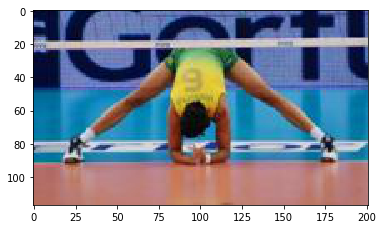

In [253]:
ran = np.random.choice(l)
print (ran)


plt.imshow(plt.imread(ran))

In [254]:
save_name = '_'.join(ran.split('/')[-2:])
print (save_name)
print ('cp -r {} ./final_results_2/{}'.format(ran,save_name))
os.system('cp -r {} /data/vcl/anirudh_rule_based/ground_truth_plot/get_all_plots/final_results_2/{}'.format(ran,save_name))

images_im0759.jpg
cp -r /data/vcl/sid/lsp_dataset/images/im0759.jpg ./final_results_2/images_im0759.jpg


0

In [255]:
!ls final_results_2/


1_trimmed_frame1114.png
courtyard_box_00_0_image_00631.jpg
courtyard_golf_00_0_image_00437.jpg
courtyard_jacket_00_0_image_00312.jpg
courtyard_jacket_00_0_image_00572.jpg
courtyard_laceShoe_00_0_image_00505.jpg
courtyard_relaxOnBench_01_0_image_00145.jpg
courtyard_relaxOnBench_01_0_image_00745.jpg
dance_104_frame1321.png
dance_104_frame3350.png
dance_105_frame0135.png
dance_106_frame1308.png
dance_10_frame0774.png
dance_119_frame0121.png
dance_122_frame1650.png
dance_125_frame2204.png
dance_126_frame0845.png
dance_16_frame1116.png
dance_17_frame0289.png
dance_17_frame0386.png
dance_20_frame1503.png
dance_39_frame1386.png
dance_4_frame1278.png
dance_6_frame0199.png
dance_7_frame0650.png
dance_7_frame1114.png
dance_9_frame0533.png
images_im0065.jpg
images_im0339.jpg
images_im0345.jpg
images_im0759.jpg
images_im0782.jpg
images_im0795.jpg
images_im0843.jpg
images_im0885.jpg
images_im0929.jpg
images_im1020.jpg
images_im1258.jpg
images_im1293.jpg
images_im1307.jpg
images_im1661.jpg
images_im

In [ ]:
fig = vis.get_figure()
ax = vis.get_ax(poses_3d[image_no-3],fig,az = 0)
vis.plot_skeleton_and_scatter(poses_3d[image_no-3],ax)

In [ ]:
q = sio.loadmat('/data/vcl/anirudh_rule_based/hmr/preds.mat')

In [ ]:
y = q['joints'].T[0]
z = q['joints'].T[1]
n = np.arange(len(q['joints'].T[1]))

fig, ax = plt.subplots()
ax.scatter(z, y)



for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

In [ ]:
len(n)

In [ ]:
def modified_mat(ske,name) :
   
    add_joint_raw = {'hips':0,
        'leftUpLeg':1,
        'rightUpLeg':2,
        'spine':3,
        'leftLeg':4,
        'rightLeg':5,
        'spine1':6,
        'leftFoot':7,
        'rightFoot':8,
        'spine2':9,
        'leftToeBase':10,
        'rightToeBase':11,
        'neck':12,
        'leftShoulder':13,
        'rightShoulder':14,
        'head':15,
        'leftArm':16,
        'rightArm':17,
        'leftForeArm':18,
        'rightForeArm':19,
        'leftHand':20,
        'rightHand':21,
        'leftHandIndex1':22,
        'rightHandIndex1':23}

    modified_joint_names = {'hips':0,
                            'neck':1,
                            'rightShoulder':2,
                            'rightForeArm':3,
                            'rightHand':4,  
                            'leftShoulder':5,
                            'leftForeArm':6,
                            'leftHand':7,
                            'head':8,
                            'rightUpLeg':9,
                            'rightLeg':10,
                            'rightFoot':11,
                            'rightToeBase':12,
                            'leftUpLeg':13,
                            'leftLeg':14,
                            'leftFoot':15,
                            'leftToeBase':16}

    if name == '2d':

        z = np.zeros((17,2))
        resized_frame = ske.copy()
        for key, value in modified_joint_names.items():
            z[value]=resized_frame[add_joint_raw[key]]

    if name == '3d':

        z = np.zeros((17,3))
        resized_frame = ske.copy()
        for key, value in modified_joint_names.items():
            z[value]=resized_frame[add_joint_raw[key]]

        one_col = z[:,[0]]
        two_col = z[:,[1]]
        three_col = z[:,[2]]
        z[:,[0]] = one_col
        z[:,[1]] = three_col
        z[:,[2]] = -two_col
        z[0]=(z[9] + z[13])/2
        z = z - z[0]
        hip_right = np.array(z[9])
        hip_left = np.array(z[13])
        pelvis_pos = (hip_right + hip_left)/2 #interpolating pelvis
        z[0] = pelvis_pos
        shoulder_left = np.array(z[5])
        shoulder_right = np.array(z[2])
        neck_pos_prior = z[1]
        neck_pos = (shoulder_left + shoulder_right)/2 #interpolating neck
        z[1] = neck_pos
        del_neck = neck_pos - neck_pos_prior
        z[8] = z[8] + del_neck #changing head_pos
        z = z - z[0] #making it root relative
        z = skeleton_utils.fit_skeleton_frame(z)
    return np.array(z)

In [ ]:
# po=modified_mat(q['theta'][0][3:3+72].reshape((24,3)))

pose_3d = q['joints3d'].reshape((24,3))
po=modified_mat(pose_3d,'3d')
poses_3d = np.squeeze(augment_pose_seq(np.expand_dims(po,0) , z_limit=(-90,-90),y_limit=(0,0)))


In [ ]:
fig = vis.get_figure()
ax = vis.get_ax(poses_3d,fig,az = 0)
vis.plot_skeleton_and_scatter(poses_3d,ax)

In [ ]:
lsp_images = glob.glob('/data/vcl/sid/lsp_dataset_original/images/*.jpg')

lsp_images_id = np.random.choice(np.arange(len(lsp_images)))

img = plt.imread(lsp_images[lsp_images_id])
plt.imshow(img)
print (img.shape)
print (lsp_images[lsp_images_id])

In [ ]:
frame_no = ['im1194','im1149','im1533','im1647','im0235','im1212','im0601','im0154','im0098','im0371','im0600','im0948','im1950']

In [ ]:
for i in frame_no:
    for j in lsp_images:
        if str(i) in j:
            folder_name = j.split('/')[-1].split('.')[0]
            dest_folder = './results_plot/{}'.format(folder_name)
            os.makedirs(dest_folder)
            os.system("cp -r {} {}".format(j,dest_folder))

In [ ]:
!ls results_plot/

In [ ]:
!rm -rf results_plot/im*

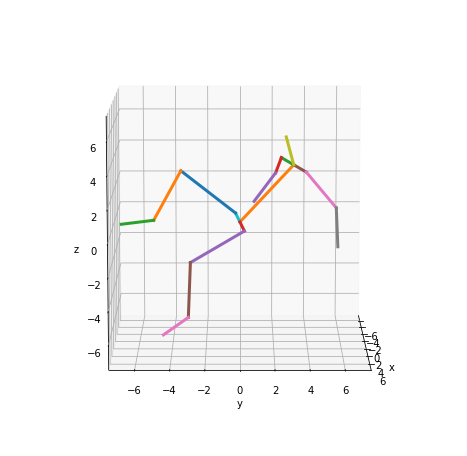

In [259]:
pose = sio.loadmat('./final_results_2/courtyard_relaxOnBench_01_0_image_00145.mat')['pose_3d']


fig = vis.get_figure()
ax = vis.get_ax(pose,fig,az = 0)
vis.plot_skeleton_and_scatter(pose,ax)

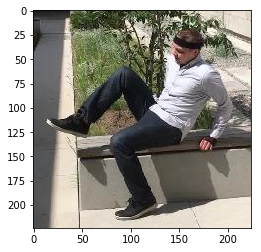

In [260]:
plt.imshow(sio.loadmat('./final_results_2/courtyard_relaxOnBench_01_0_image_00145.mat')['image'])

In [ ]:
j = glob.glob('/data/vcl/anirudh_rule_based/ground_truth_plot/get_all_plots/results_folder/*')

In [ ]:
for i in j :
    if "ann_imgs" in i:
        continue
    print (os.listdir(i))
    for k in os.listdir(i):
        if '.mat' in k:
            mat_name = k
            print (sio.loadmat(i+'/'+k).keys())
            try :
                p = sio.loadmat(i+'/'+k)['poses_3d']
            except :
                p = sio.loadmat(i+'/'+k)['pose_3d']
        else :
            img = plt.imread(i+'/'+k)
    sio.savemat(i+'/'+mat_name,{'image':img , 'poses_3d':p})


In [4]:

data = '/data/vcl/anirudh_rule_based/youtube_data/youtube_data/extra_youtube.mat'

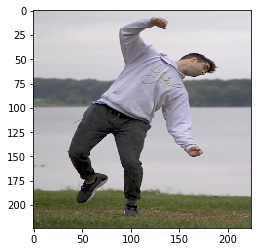

In [5]:
img = sio.loadmat(data)['image']
# img = np.array([cv2.resize(i,(224,224)) for i in img[0]])

plt.imshow(img[4])

In [6]:
np.array(img).shape

(5, 224, 224, 3)

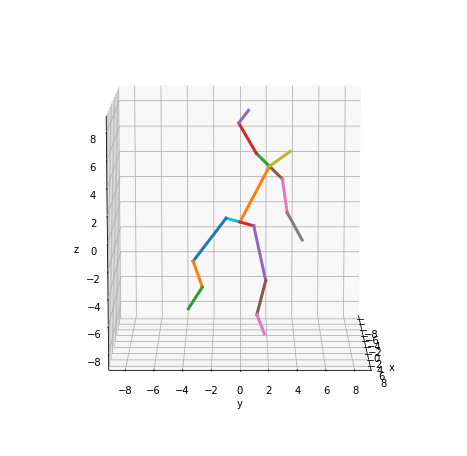

In [7]:
pose = sio.loadmat(data)['poses_3d'][4]
pose.shape

fig = vis.get_figure()
ax = vis.get_ax(pose,fig,az = 0)
vis.plot_skeleton_and_scatter(pose,ax)

In [9]:
sio.savemat(data , {'image':img , 'poses_3d':pose})

In [63]:
 k = img.reshape((5,1)).shape


In [65]:
k[0]


5

In [45]:
img.shape

(5,)